In [2]:
import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm

In [3]:
BATCH_SIZE = 128
NUM_WORKERS = 3
MULT = 2
device = "cuda" if torch.cuda.is_available() else "cpu" 

print("Training on {}".format(device))

Training on cuda


In [4]:
torch_utils.seed_everything(43)

In [5]:
class MyData(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        if y is not None:
            assert len(y)==len(X)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = np.array(self.X[idx,:], dtype='uint8').reshape(28,28)
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.y is not None:
            return img, self.y[idx]
        return img

In [6]:
train_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.RandomRotation(10),
    txf.RandomAffine(degrees=7, translate=(0.3,0.3), scale=(0.8, 1.2), shear=7,),
    txf.ToTensor(),
    txf.Normalize([0.485], [0.229])
])

test_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.ToTensor(),
    txf.Normalize([0.485], [0.229])
])

In [7]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
dig_df = pd.read_csv("./Dig-MNIST.csv")
sub_df = pd.read_csv("./sample_submission.csv")

In [8]:
target = train_df["label"]
train_df.drop("label", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, stratify=target, random_state=947, test_size=0.1)

In [10]:
len(X_train), len(X_valid)

(54000, 6000)

In [11]:
dataset_train = MyData(X_train.to_numpy(), y_train.to_numpy(), train_transforms)
dataset_valid = MyData(X_valid.to_numpy(), y_valid.to_numpy(), test_transforms)
dataset_test = MyData(test_df.to_numpy(), transforms=test_transforms)

In [12]:
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

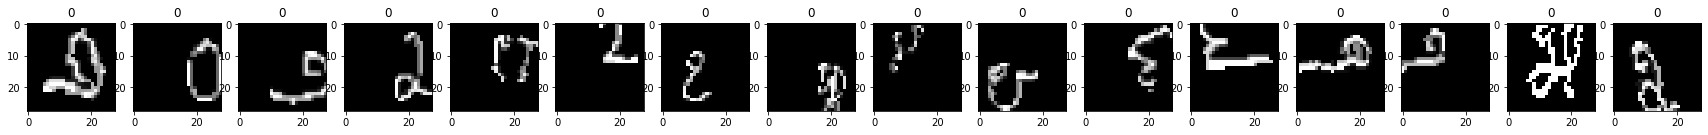

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap="gray")
    break

In [14]:
class FWiktorNet(nn.Module):
    def __init__(self, n_classes, drop_prob=0.3):
        super(FWiktorNet, self).__init__()
        
        self.conv1 = torch_utils.CNNLayer(1, MULT*32)
        self.conv2 = torch_utils.CNNLayer(MULT*32, MULT*32)
        
        self.conv3 = torch_utils.CNNLayer(MULT*32, MULT*64)
        self.conv4 = torch_utils.CNNLayer(MULT*64, MULT*64)
        
        self.conv5 = torch_utils.CNNLayer(MULT*64, MULT*128)
        self.conv6 = torch_utils.CNNLayer(MULT*128, MULT*128)
        
        self.fc1 = torch_utils.FCLayer(MULT*128*3*3, 256)
        self.fc2 = torch_utils.FCLayer(256, n_classes)
        
        
        self.maxpool = nn.MaxPool2d(2, 2) 
        self.drop = nn.Dropout2d(p=drop_prob)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.drop(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [15]:
# Learning Rate Finder https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
def find_lr(model, optimizer, criterion, trn_loader, device="cpu", init_value = 1e-8, final_value=10., beta = 0.98):
    model = model.to(device)
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in tqdm(trn_loader):
        torch_utils.clear_cuda()
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs = data[0].to(device)
        labels = data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta)*loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [16]:
model = FWiktorNet(10)
criterion = torch_utils.LabelSmoothingLoss(10, 0.15)
optimizer = optim.RMSprop(model.parameters(), lr = 0.005)

In [17]:
# log_lrs, losses = find_lr(model, optimizer, criterion, train_loader, device="cuda")

In [18]:
# plt.plot(log_lrs[10:-5],losses[10:-5])

In [19]:
# log_lrs[np.argmin(losses)]

In [20]:
# 23040380e-8
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [23]:
model = FWiktorNet(10)
criterion = torch_utils.LabelSmoothingLoss(10, smoothing=0.15)
optimizer = optim.RMSprop(model.parameters(), lr = e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True, patience=5)
EPOCHS = 80

In [21]:
# import time
# history = pd.DataFrame()
# for epoch in range(EPOCHS):
#     curt = time.time()
#     torch_utils.clear_cuda()
#     print("Current Learning Rate: {}".format(get_lr(optimizer)))
    
#     tr_loss, tr_acc = torch_utils.train_classifier(model, optimizer, criterion, epoch+1, train_loader, device=device,print_interval=100)
#     vl_loss, vl_acc = torch_utils.test_classifier(model, criterion, device, valid_loader)
    
#     scheduler.step(vl_loss)
#     print("Val Loss: {}  Time Taken: {}\n".format(vl_loss, time.time()-curt))
    
#     history.loc[epoch, "train_loss"] = tr_loss
#     history.loc[epoch, "valid_loss"] = vl_loss
#     history.loc[epoch, "train_accuracy"] = tr_acc
#     history.loc[epoch, "valid_accuracy"] = vl_acc

In [22]:
history["train_loss"].plot()

In [23]:
history["train_accuracy"].plot()

In [24]:
history["valid_loss"].plot()

In [25]:
history["valid_accuracy"].plot()

In [31]:
# preds = []
# for x in test_loader:
#     y_pred = model(x.to(device))
#     y_pred = y_pred.argmax(dim=1)
#     preds.extend(y_pred.cpu().numpy())
# sub_df["label"] = pd.Series(preds)

In [32]:
# sub_df.to_csv("submission.csv", index=False)

In [33]:
# sub_df

In [34]:
# torch.save(model.state_dict(), "FWiktorNet_Smooth_80.pt")

In [35]:
model.load_state_dict(torch.load("FWiktorNet_Smooth_80.pt", map_location=device))

<All keys matched successfully>

In [40]:
def tta(x):
    tx5 = txf.FiveCrop(25)
    y = tx5(x)
    print(y)

In [41]:
preds = []
for x in test_loader:
    tta(x)
    break
#     y_pred = model(x.to(device))
#     y_pred = y_pred.argmax(dim=1)
#     preds.extend(y_pred.cpu().numpy())
# sub_df["label"] = pd.Series(preds)

TypeError: cannot unpack non-iterable builtin_function_or_method object

In [82]:
test_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.FiveCrop(20),
    txf.Lambda(lambda crops: [txf.Resize(28)(crop) for crop in crops]),
    txf.Lambda(lambda crops: torch.stack([txf.ToTensor()(crop) for crop in crops]))
])

In [89]:
dataset_test = MyData(test_df.to_numpy(), transforms=test_transforms)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [88]:
preds = []
for data in tqdm(test_loader):
    batch_size, n_crops, c, h, w = data.size()
    data = data.view(-1, c, h, w)
    output = model(data)
    y_pred = output.view(batch_size, n_crops, -1).mean(1)
#     print(output)
    y_pred = y_pred.argmax(dim=1)
    preds.extend(y_pred.cpu().numpy())
sub_df["label"] = pd.Series(preds)

In [91]:
sub_df

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,0
4997,4997,1
4998,4998,6
